# Estimating the effect of a Member Rewards program
An example on how DoWhy can be used to estimate the effect of a subscription or a rewards program for customers. 

Suppose that a website has a membership rewards program where customers receive additional benefits if they sign up. How do we know if the program is effective? Here the relevant causal question is:
> What is the impact of offering the membership rewards program on total sales?

And the equivalent counterfactual question is, 
> If the current members had not signed up for the program, how much less would they have spent on the website?

In formal language, we are interested in the Average Treatment Effect on the Treated (ATT). 

##  I. Formulating the causal model
Suppose that the rewards program was introduced in January 2019. 

The **outcome** variable is the *total spends at the end of the year*.

We have data on all monthly transactions of every user and on the time of signup for those who chose to signup for the rewards program. 

Here's what the data looks like.

In [8]:
# Creating some simulated data for our example

import pandas as pd
import numpy as np

num_users = 10000
num_months = 12

# signup_months == 0 means customer did not sign up
signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users)

df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) # centered at 500

})

# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"] > 0

# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10

# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100


In [10]:
df.head(36)

,user_id,signup_month,month,spend,treatment
0,0,6,1,493,True
1,0,6,2,461,True
2,0,6,3,459,True
3,0,6,4,439,True
4,0,6,5,412,True
5,0,6,6,470,True
6,0,6,7,541,True
7,0,6,8,544,True
8,0,6,9,516,True
9,0,6,10,505,True


### Question: How do you forseen the causal model? (psss: don't look into the next cell)

### The importance of time
Time plays a crucial role in modeling this problem. 

Rewards signup can affect the future transactions, but not those that happened before it. In fact, the transactions prior to the rewards signup can be assumed to cause the rewards signup decision. Therefore we split up the variables for each user:

1. Activity prior to the treatment (assumed a cause of the treatment)
2. Activity after the treatment (is the outcome of applying treatment)

Of course, many important variables that affect signup and total spend are missing (e.g., the type of products bought, length of a user's account, geography, etc.). So we'll need a node denoting `Unobserved Confounders`. 

Below is the causal graph for a user who signed up in month `i=3`. The analysis will be similar for any `i`. 

In [11]:
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

In [12]:
# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)

print(df_i_signupmonth)


      user_id  signup_month  treatment  pre_spends  post_spends
0           1             0      False       479.0   415.777778
1           2             3       True       481.5   509.777778
2           4             0      False       479.0   425.555556
3           8             0      False       526.5   423.777778
4           9             0      False       520.0   422.444444
...       ...           ...        ...         ...          ...
5448     9987             0      False       502.5   422.444444
5449     9989             0      False       444.5   414.000000
5450     9991             0      False       499.5   405.222222
5451     9996             0      False       518.0   416.888889
5452     9999             3       True       490.5   515.888889

[5453 rows x 5 columns]


In [13]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z -> treatment;
U[label="Unobserved Confounders"]; 
pre_spends -> treatment;
treatment -> post_spends;
signup_month -> post_spends;
signup_month -> pre_spends;
signup_month -> treatment;
U -> treatment;
U -> pre_spends;
U -> post_spends;
}"""

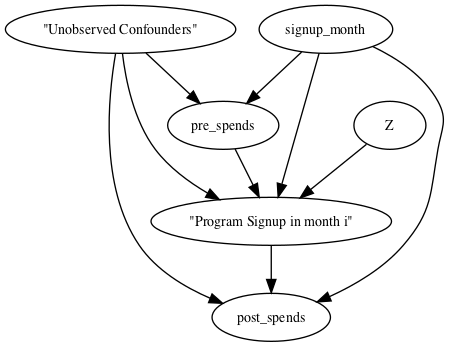

In [14]:

model = dowhy.CausalModel(data=df_i_signupmonth,
                    graph=causal_graph.replace("\n", " "),
                    treatment="treatment",
                    outcome="post_spends")

model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

More generally, we can include any activity data for the customer in the above graph. All prior- and post-activity data will occupy the same place (and have the same edges) as the Amount spent node (prior and post respectively). 

## II. Identifying the causal effect
For the sake of this example, let us assume that unobserved confounding does not play a big part. 

In [15]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                        
────────────(Expectation(post_spends|signup_month,pre_spends))
d[treatment]                                                  
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(post_spends, [Z])*Derivative([treatment], [Z])**(-1))
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Based on the graph, DoWhy determines that the signup month and amount spent in the pre-treatment months (`signup_month`, `pre_spend`) needs to be conditioned on.

## III. Estimating the effect
We now estimate the effect based on the backdoor estimand, setting the target units to "att".

In [19]:

estimate = model.estimate_effect(identified_estimand, 
                                method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)

/Users/ESMoraEn/anaconda3/envs/causality/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 100.02074391988558



The analysis tells us the Average Treatment Effect on the Treated (ATT). That is, the average effect on total spend for the customers that signed up for the Rewards Program in month `i=3` (compared to the case where they had not signed up). We can similarly calculate the effects for customers who signed up in any other month by changing the value of `i`(line 2 above) and then rerunning the analysis. 

Note that the estimation suffers from left and right-censoring. 
1. **Left-censoring**: If a customer signs up in the first month, we do not have enough transaction history to match them to similar customers who did not sign up (and thus apply the backdoor identified estimand). 
2. **Right-censoring**: If a customer signs up in the last month, we do not enough *future* (post-treatment) transactions to estimate the outcome after signup. 

Thus, even if the effect of signup was the same across all months, the *estimated effects* may be different by month of signup, due to lack of data (and thus high variance in estimated pre-treatment or post-treatment transactions activity).

## IV. Refuting the estimate
We refute the estimate using the placebo treatment refuter. This refuter substitutes the treatment by an independent random variable and checks whether our estimate now goes to zero (it should!).

In [20]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=2)
print(refutation)

/Users/ESMoraEn/anaconda3/envs/causality/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ESMoraEn/anaconda3/envs/causality/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:100.02074391988558
New effect:0.2789699570815438
p value:1.2913101538383583e-70

